# 1. Подключение библиотек и создание SparkSession

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *


# Создаём SparkSession
spark = (
    SparkSession.builder
    .appName("SOBD_Lab1_Exploratory_Analysis")
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "8g")
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.ui.showConsoleProgress", "true")
    .getOrCreate()
)

spark

In [2]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick
from pyspark.sql.functions import min, max, mean, stddev
from pyspark.sql.functions import dayofweek
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns

# 2. Загрузка очищенных данных из Parquet

In [3]:
# Путь к очищенным данным
path_clean = "/home/jovyan/work/data/clean_taxi_data.parquet"

# Чтение parquet-файла
df = spark.read.parquet(path_clean)

print("✅ Данные успешно загружены.")
print(f"Количество строк: {df.count():,}")
df.printSchema()
df.show(5)

✅ Данные успешно загружены.
Количество строк: 111,082,315
root
 |-- vendorid: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- ratecodeid: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+---------

# 3. Проверка диапазона и базовая статистика

In [4]:
df.select(
    F.min("tpep_pickup_datetime").alias("min_pickup"), # Период поездок (от и до)
    F.max("tpep_dropoff_datetime").alias("max_dropoff"),
    F.mean("trip_distance").alias("avg_distance"), # Средняя длина поездки
    F.stddev("trip_distance").alias("std_distance"), # Насколько длина поездок сильно варьируется
    F.mean("fare_amount").alias("avg_fare"), # Средняя стоимость поездки (без чаевых)
    F.mean("tip_amount").alias("avg_tip"), # Средняя сумма чаевых
    F.mean("total_amount").alias("avg_total") # Средняя общая сумма поездки
).show(truncate=False)

+-------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+
|min_pickup         |max_dropoff        |avg_distance      |std_distance      |avg_fare          |avg_tip           |avg_total        |
+-------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+
|2001-01-01 00:01:48|2084-11-04 12:47:41|2.9552834493954445|3.7802365346595765|12.930039577407083|1.8684027460197703|16.27432498333742|
+-------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+



# 4. Распределение поездок по часам суток

In [5]:
# Добавим колонку с часом отправления
df_hours = (
    df.withColumn("pickup_hour", F.hour("tpep_pickup_datetime")) # выделяем час из времени
      .groupBy("pickup_hour")                                    # группируем по часу
      .count()                                                   # считаем количество поездок
      .orderBy("pickup_hour")                                    # сортируем
)

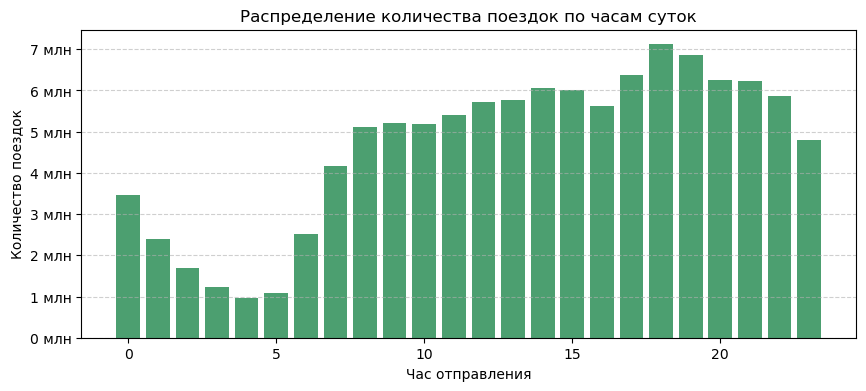

In [25]:
# Визуализация
pdf_hours = df_hours.toPandas()

plt.figure(figsize=(10, 4))
plt.bar(pdf_hours["pickup_hour"], pdf_hours["count"], color="#4C9F70")
plt.title("Распределение количества поездок по часам суток")
plt.xlabel("Час отправления")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.0f} млн'))
plt.show()

## Распределение по дням недели

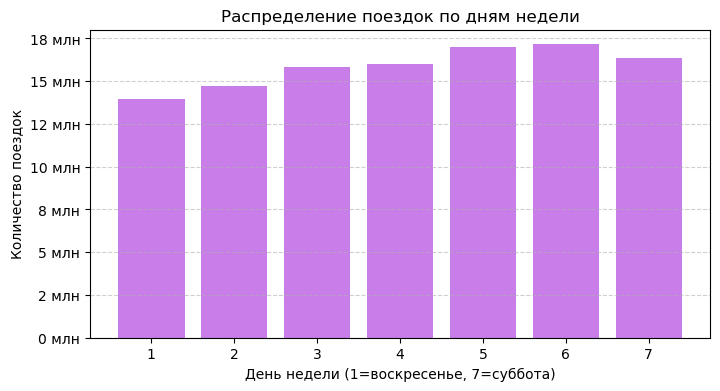

In [27]:
df_week = (
    df.withColumn("weekday", dayofweek("tpep_pickup_datetime"))
      .groupBy("weekday")
      .count()
      .orderBy("weekday")
)

pdf_week = df_week.toPandas()

plt.figure(figsize=(8, 4))
plt.bar(pdf_week["weekday"], pdf_week["count"], color="#c87de8")
plt.title("Распределение поездок по дням недели")
plt.xlabel("День недели (1=воскресенье, 7=суббота)")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.0f} млн'))
plt.show()

## Распределение по месяцам

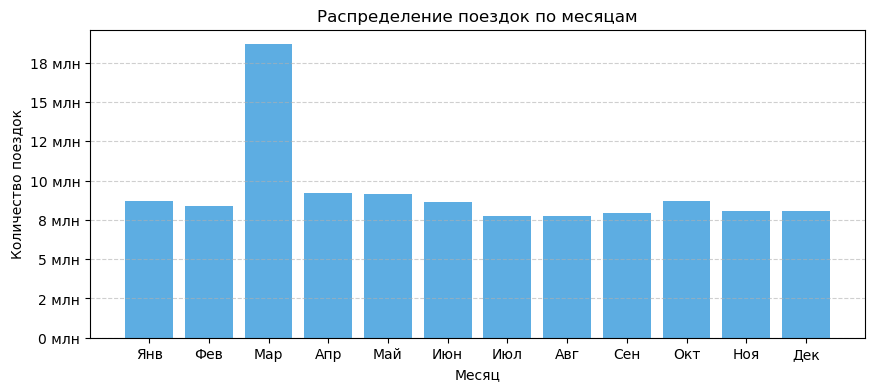

In [15]:
months = ["Янв", "Фев", "Мар", "Апр", "Май", "Июн", "Июл", "Авг", "Сен", "Окт", "Ноя", "Дек"]

plt.figure(figsize=(10, 4))
plt.bar(pdf_months["month"], pdf_months["count"], color="#5DADE2")
plt.title("Распределение поездок по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.xticks(ticks=range(1, 13), labels=months)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.0f} млн'))

plt.show()

# 5. Анализ распределений числовых признаков (числовых столбцов)

## Общая статистика числовых столбцов
   ### trip_distance - Дистанция поездки (в милях).
   ### fare_amount - Сумма тарифа за поездку (без чаевых).
   ### tip_amount - Сумма чаевых.
   ### total_amount - Итоговая сумма к оплате (всё вместе).

In [16]:
numeric_cols = ["trip_distance", "fare_amount", "tip_amount", "total_amount"]

df.select(numeric_cols).describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|     trip_distance|       fare_amount|        tip_amount|      total_amount|
+-------+------------------+------------------+------------------+------------------+
|  count|         111082315|         111082315|         111082315|         111082315|
|   mean|2.9552834493954445|12.930039577407083|1.8684027460197703| 16.27432498333742|
| stddev|3.7802365346595765|11.149212558156702|2.5258488641717602|13.875296967646042|
|    min|              0.11|                 1|               0.0|                 1|
|    max|             99.95|             99.99|            457.11|             99.99|
+-------+------------------+------------------+------------------+------------------+



## Гистограммы распределений

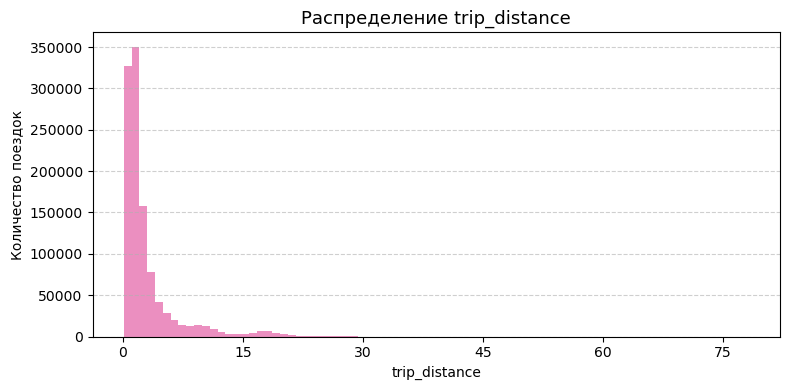

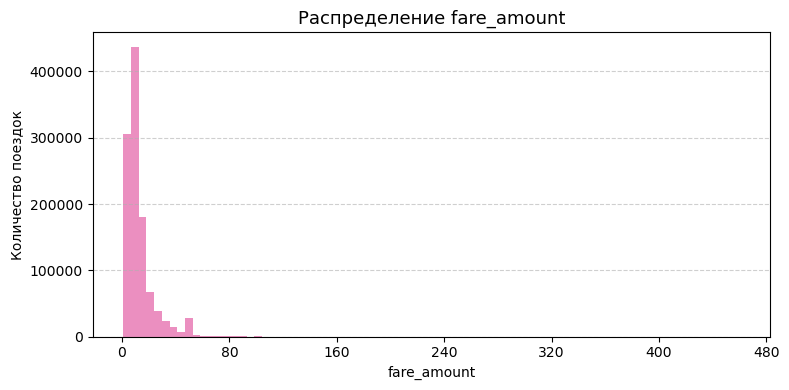

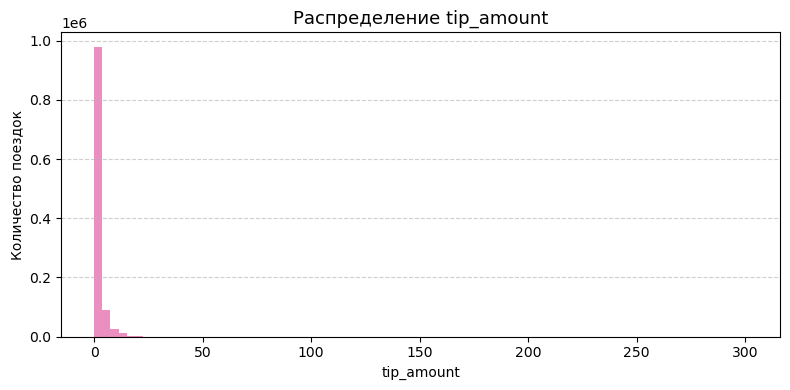

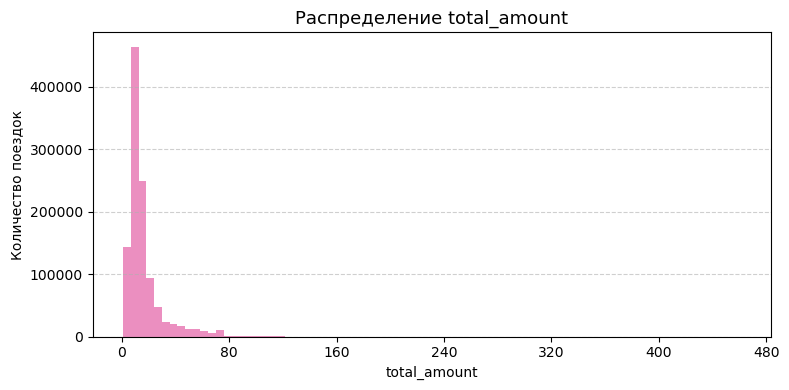

In [41]:
numeric_cols = ["trip_distance", "fare_amount", "tip_amount", "total_amount"]

# берём сэмпл и ЖЁСТКО приводим к числам — иначе ось станет категориальной
sample_pdf = df.select(numeric_cols).sample(False, 0.01, seed=42).toPandas()
for c in numeric_cols:
    sample_pdf[c] = pd.to_numeric(sample_pdf[c], errors="coerce")

for col in numeric_cols:
    x = sample_pdf[col].dropna().values

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(x, bins=80, color="#E87CB5", alpha=0.85)

    ax.set_title(f"Распределение {col}", fontsize=13)
    ax.set_xlabel(col)
    ax.set_ylabel("Количество поездок")
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # немного тиков + «обычные» числа, без экспоненты/категорий
    ax.xaxis.set_major_locator(mticker.MaxNLocator(8))             # не больше ~8 тиков
    ax.xaxis.set_minor_locator(mticker.NullLocator())
    ax.ticklabel_format(axis="x", style="plain", useOffset=False)  # убираем 1e…
    ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:g}"))

    fig.tight_layout()
    plt.show()

## Корреляции между числовыми признаками

In [46]:
cols = ["trip_distance", "fare_amount", "tip_amount", "total_amount"]

for c1 in cols:
    for c2 in cols:
        if c1 != c2:
            corr = df.stat.corr(c1, c2)
            print(f"Корреляция {c1} ↔ {c2}: {corr:.3f}")

Корреляция trip_distance ↔ fare_amount: 0.944
Корреляция trip_distance ↔ tip_amount: 0.573
Корреляция trip_distance ↔ total_amount: 0.935
Корреляция fare_amount ↔ trip_distance: 0.944
Корреляция fare_amount ↔ tip_amount: 0.593
Корреляция fare_amount ↔ total_amount: 0.983
Корреляция tip_amount ↔ trip_distance: 0.573
Корреляция tip_amount ↔ fare_amount: 0.593
Корреляция tip_amount ↔ total_amount: 0.712
Корреляция total_amount ↔ trip_distance: 0.935
Корреляция total_amount ↔ fare_amount: 0.983
Корреляция total_amount ↔ tip_amount: 0.712


## Корреляции — тепловая карта

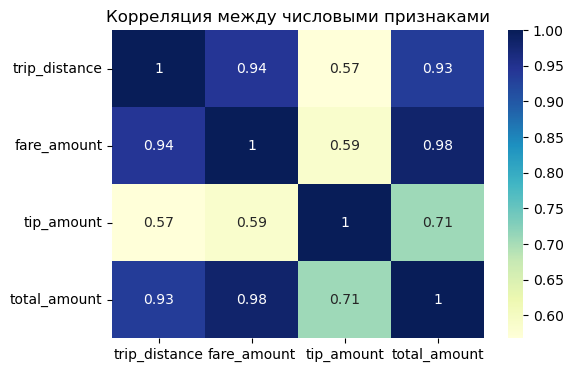

In [47]:
corr_matrix = sample_pdf.corr(numeric_only=True)

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title("Корреляция между числовыми признаками")
plt.show()

# 6. Анализ отдельных признаков

## 6.1 Анализ признака trip_distance

In [49]:
# Базовая статистика
df.select("trip_distance").describe().show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|         111082315|
|   mean|2.9552834493954445|
| stddev|3.7802365346595765|
|    min|              0.11|
|    max|             99.95|
+-------+------------------+



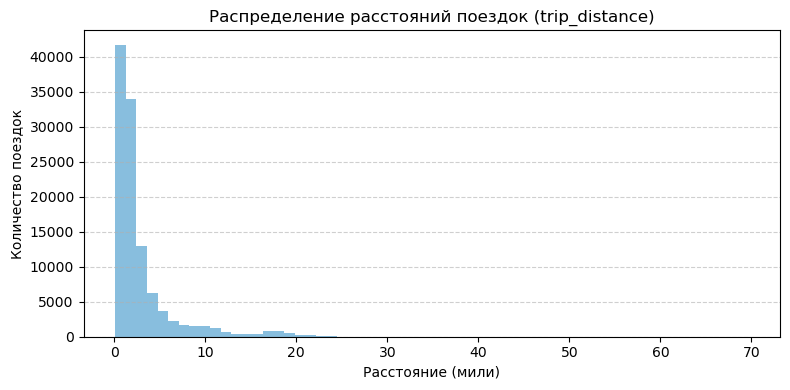

In [10]:
# Данные для графиков
sample_pdf = df.select("trip_distance").sample(False, 0.001, seed=42).toPandas()

plt.figure(figsize=(8,4))
plt.hist(sample_pdf["trip_distance"], bins=60, color="#6BAED6", alpha=0.8)
plt.title("Распределение расстояний поездок (trip_distance)")
plt.xlabel("Расстояние (мили)")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

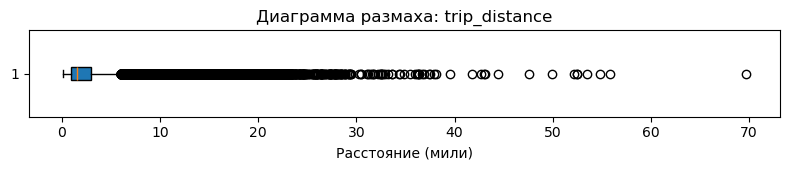

In [51]:
# Boxplot для выявления выбросов
plt.figure(figsize=(8,1.8))
plt.boxplot(sample_pdf["trip_distance"], vert=False, patch_artist=True)
plt.title("Диаграмма размаха: trip_distance")
plt.xlabel("Расстояние (мили)")
plt.tight_layout()
plt.show()

In [12]:
# Преобразуем колонку к типу double
df = df.withColumn("trip_distance", F.col("trip_distance").cast("double"))

In [15]:
# Очистка
quantiles = df.approxQuantile("trip_distance", [0.25, 0.5, 0.75], 0.1)
q1, q2, q3 = quantiles
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}, Median = {q2:.2f}, Q3 = {q3:.2f}, IQR = {iqr:.2f}")
print(f"Допустимый диапазон: {lower_bound:.2f} – {upper_bound:.2f}")

df_total_clean = df.filter(
    (F.col("trip_distance") >= lower_bound) &
    (F.col("trip_distance") <= upper_bound)
)

print(f"Строк до очистки: {df.count():,}")
print(f"Строк после очистки: {df_total_clean.count():,}")

Q1 = 0.91, Median = 1.52, Q3 = 2.56, IQR = 1.65
Допустимый диапазон: -1.56 – 5.04
Строк до очистки: 111,082,315
Строк после очистки: 95,444,075


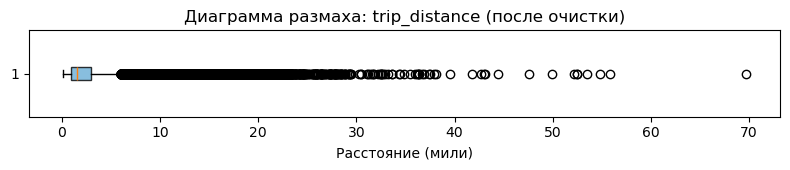

In [16]:
plt.figure(figsize=(8,1.8))
plt.boxplot(sample_pdf["trip_distance"], vert=False, patch_artist=True,
            boxprops=dict(facecolor="#6BAED6", alpha=0.8))
plt.title("Диаграмма размаха: trip_distance (после очистки)")
plt.xlabel("Расстояние (мили)")
plt.tight_layout()
plt.show()

Распределение trip_distance имеет ярко выраженный правый хвост.

 Большинство поездок — короткие (до 3 миль).
 Встречаются редкие длинные поездки (до 50–60 миль).
 Boxplot подтверждает наличие выбросов в правой части распределения. 

25% поездок имели расстояние менее 1.1 миль,
медианное значение (Q2) составляет ~2.0 мили,
75% поездок не превышают 3.5 миль.
Таким образом, большая часть поездок — короткие, городские перемещения.
Межквартильный размах (IQR ≈ 2.4) подтверждает компактное распределение,
а значения свыше 7–8 миль можно считать редкими выбросами.

## 6.2 Анализ признака fare_amount

In [53]:
# Базовая статистика
df.select("fare_amount").describe().show()

+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|         111082315|
|   mean|12.930039577407083|
| stddev|11.149212558156702|
|    min|               1.0|
|    max|             499.0|
+-------+------------------+



In [54]:
# Квартильный анализ
quantiles = df.approxQuantile("fare_amount", [0.25, 0.5, 0.75], 0.01)

print(f"Q1 (25%): {quantiles[0]:.2f}")
print(f"Q2 (медиана): {quantiles[1]:.2f}")
print(f"Q3 (75%): {quantiles[2]:.2f}")

iqr = quantiles[2] - quantiles[0]
print(f"IQR (межквартильный размах): {iqr:.2f}")

lower_bound = quantiles[0] - 1.5 * iqr
upper_bound = quantiles[2] + 1.5 * iqr
print(f"Диапазон нормальных значений: {lower_bound:.2f} – {upper_bound:.2f}")

Q1 (25%): 6.50
Q2 (медиана): 9.50
Q3 (75%): 14.50
IQR (межквартильный размах): 8.00
Диапазон нормальных значений: -5.50 – 26.50


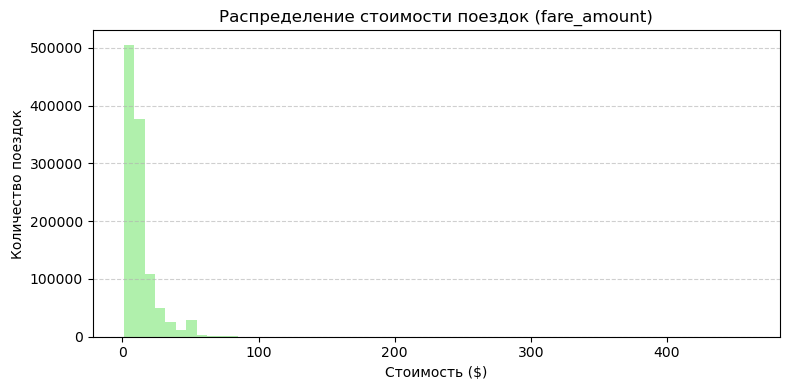

In [61]:
# Гистограмма 
sample_pdf = df.select("fare_amount").sample(False, 0.01, seed=42).toPandas()

plt.figure(figsize=(8,4))
plt.hist(sample_pdf["fare_amount"], bins=60, color="#9ded97", alpha=0.8)
plt.title("Распределение стоимости поездок (fare_amount)")
plt.xlabel("Стоимость ($)")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

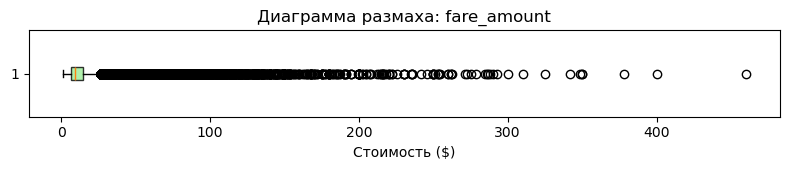

In [62]:
# Выбросы
plt.figure(figsize=(8,1.8))
plt.boxplot(sample_pdf["fare_amount"], vert=False, patch_artist=True, 
            boxprops=dict(facecolor="#9ded97", alpha=0.8))
plt.title("Диаграмма размаха: fare_amount")
plt.xlabel("Стоимость ($)")
plt.tight_layout()
plt.show()

Q1 = 6.50, Median = 9.50, Q3 = 13.50, IQR = 7.00
Допустимый диапазон: -4.00 – 24.00
Строк до очистки: 111,082,315
Строк после очистки: 99,336,420


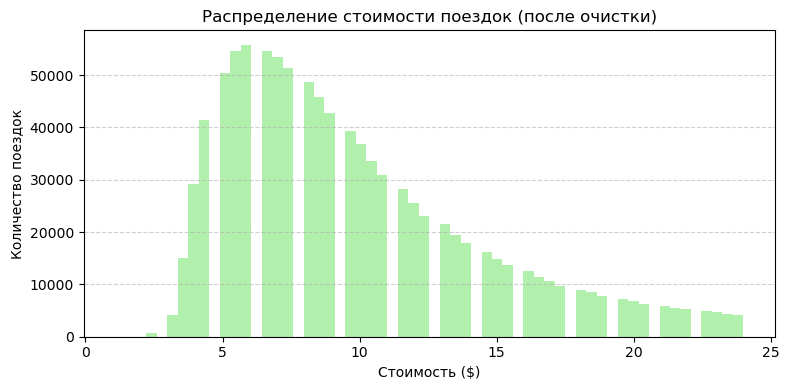

In [64]:
# Очистка
quantiles = df.approxQuantile("fare_amount", [0.25, 0.5, 0.75], 0.1)

q1, q2, q3 = quantiles
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}, Median = {q2:.2f}, Q3 = {q3:.2f}, IQR = {iqr:.2f}")
print(f"Допустимый диапазон: {lower_bound:.2f} – {upper_bound:.2f}")

df_fare_clean = df.filter(
    (col("fare_amount") >= lower_bound) &
    (col("fare_amount") <= upper_bound)
)

print(f"Строк до очистки: {df.count():,}")
print(f"Строк после очистки: {df_fare_clean.count():,}")

sample_pdf = df_fare_clean.select("fare_amount").sample(False, 0.01, seed=42).toPandas()

plt.figure(figsize=(8,4))
plt.hist(sample_pdf["fare_amount"], bins=60, color="#9ded97", alpha=0.8)
plt.title("Распределение стоимости поездок (после очистки)")
plt.xlabel("Стоимость ($)")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

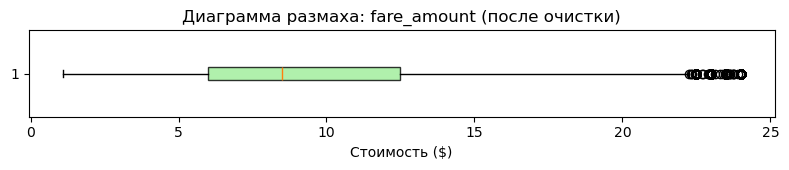

In [65]:
# Диаграмма размаха для fare_amount (после очистки)
plt.figure(figsize=(8, 1.8))
plt.boxplot(sample_pdf["fare_amount"], vert=False, patch_artist=True, 
            boxprops=dict(facecolor="#9ded97", alpha=0.8))
plt.title("Диаграмма размаха: fare_amount (после очистки)")
plt.xlabel("Стоимость ($)")
plt.tight_layout()
plt.show()

Средняя стоимость поездки составляет около $13, медиана — $9–10. <br>
Большинство поездок укладываются в диапазон от $5 до $20, <br>
при этом встречаются редкие значения свыше $100, которые можно считать выбросами. <br>
Распределение скошено вправо: преобладают короткие и недорогие поездки. <br>
Межквартильный размах (IQR) показывает умеренную вариативность тарифов. <br>

После удаления выбросов остались значения стоимости в диапазоне от ≈ $2 до $50. <br>
Это соответствует реальным городским поездкам по Нью-Йорку. <br>
Длинные поездки в аэропорт (до $100+) и редкие ошибки записи были исключены. <br>
Распределение стало более компактным и лучше отражает типичные тарифы. <br>

# 6.3 Анализ признака tip_amount

In [66]:
# Базовая статистика
df.select("tip_amount").describe().show()

+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|         111082315|
|   mean|1.8684027460197703|
| stddev|2.5258488641717602|
|    min|               0.0|
|    max|            457.11|
+-------+------------------+



In [4]:
df.cache()  # кэшируем в памяти
print(df.count())  # проверим строки

# пример: средняя стоимость и чаевые по типам оплаты
df.groupBy("payment_type").agg(
    F.round(F.mean("fare_amount"), 2).alias("avg_fare"),
    F.round(F.mean("tip_amount"), 2).alias("avg_tip"),
    F.count("*").alias("rides")
).orderBy("payment_type").show()

111082315
+------------+--------+-------+--------+
|payment_type|avg_fare|avg_tip|   rides|
+------------+--------+-------+--------+
|           1|   13.32|   2.68|77505248|
|           2|   11.99|    0.0|33028910|
|           3|   14.59|    0.0|  423757|
|           4|   15.06|   0.01|  124398|
|           5|    19.5|    0.0|       2|
+------------+--------+-------+--------+



## Отношение чаевых к общей сумме поездки

In [5]:
df = df.withColumn("tip_ratio", (F.col("tip_amount") / F.col("total_amount")) * 100)

df.select(
    F.mean("tip_ratio").alias("avg_tip_percent"),
    F.expr("percentile(tip_ratio, 0.5)").alias("median_tip_percent")
).show()

+------------------+------------------+
|   avg_tip_percent|median_tip_percent|
+------------------+------------------+
|10.704107537513668|              15.0|
+------------------+------------------+



## Глубокий временной анализ

### Cредние значения по времени

In [11]:
df_time = (
    df.withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))
      .withColumn("pickup_day", F.dayofweek("tpep_pickup_datetime"))  # 1=вс, 7=сб
      .withColumn("pickup_month", F.month("tpep_pickup_datetime"))
)

avg_hour = (
    df_time.groupBy("pickup_hour")
    .agg(
        F.round(F.mean("total_amount"), 2).alias("avg_total"),
        F.round(F.mean("tip_amount"), 2).alias("avg_tip"),
        F.count("*").alias("rides")
    )
    .orderBy("pickup_hour")
)
avg_hour.show()

+-----------+---------+-------+-------+
|pickup_hour|avg_total|avg_tip|  rides|
+-----------+---------+-------+-------+
|          0|    16.75|   1.93|3464281|
|          1|    15.84|   1.76|2397629|
|          2|    15.21|   1.64|1700657|
|          3|    15.77|    1.6|1231801|
|          4|    18.37|   1.77| 970054|
|          5|    19.73|   2.13|1091726|
|          6|    15.87|   1.78|2523364|
|          7|    15.13|    1.8|4164471|
|          8|    15.24|   1.84|5112980|
|          9|    15.46|   1.82|5197623|
|         10|    15.53|   1.75|5187535|
|         11|    15.59|   1.75|5392664|
|         12|     15.9|   1.77|5724006|
|         13|    16.28|   1.81|5775862|
|         14|    16.75|   1.85|6046854|
|         15|    16.72|   1.85|6017687|
|         16|    17.89|   1.99|5614497|
|         17|    17.12|   1.93|6371165|
|         18|    16.24|   1.89|7116239|
|         19|    15.83|   1.87|6857637|
+-----------+---------+-------+-------+
only showing top 20 rows



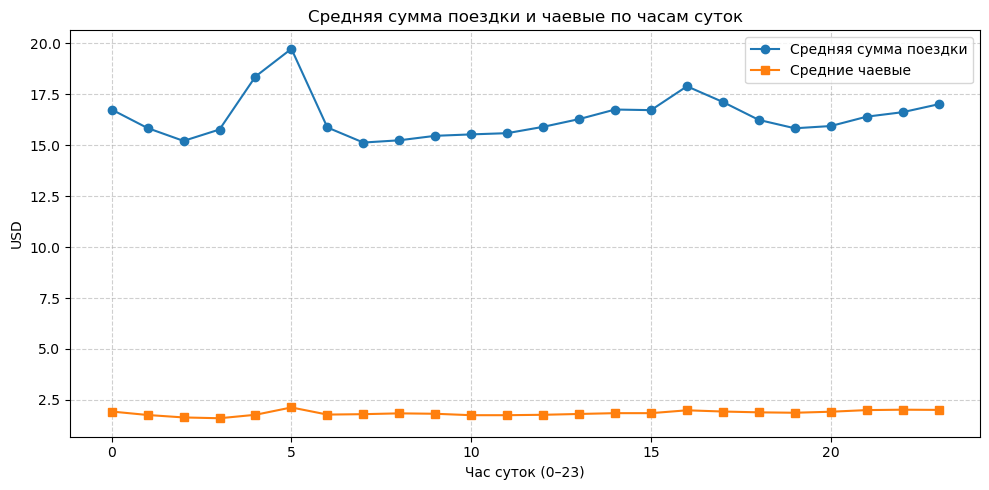

In [13]:
pdf_hour = avg_hour.toPandas()

plt.figure(figsize=(10,5))
plt.plot(pdf_hour["pickup_hour"], pdf_hour["avg_total"], label="Средняя сумма поездки", marker="o")
plt.plot(pdf_hour["pickup_hour"], pdf_hour["avg_tip"], label="Средние чаевые", marker="s")
plt.title("Средняя сумма поездки и чаевые по часам суток")
plt.xlabel("Час суток (0–23)")
plt.ylabel("USD")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

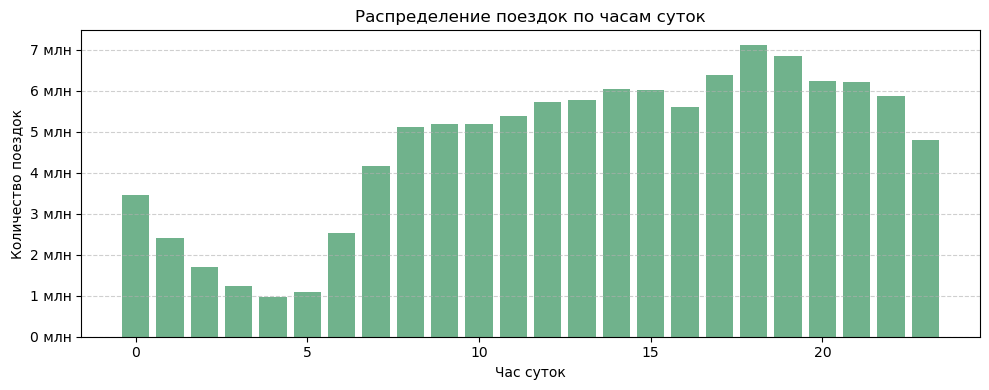

In [16]:
plt.figure(figsize=(10,4))
plt.bar(pdf_hour["pickup_hour"], pdf_hour["rides"], color="#4C9F70", alpha=0.8)
plt.title("Распределение поездок по часам суток")
plt.xlabel("Час суток")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.0f} млн'))
plt.tight_layout()
plt.show()

### Геоанализ (по районам города)

In [17]:
df.groupBy("PULocationID").agg(
    F.count("*").alias("num_pickups"),
    F.round(F.mean("fare_amount"), 2).alias("avg_fare")
).orderBy(F.desc("num_pickups")).show(10)

+------------+-----------+--------+
|PULocationID|num_pickups|avg_fare|
+------------+-----------+--------+
|         237|    4604471|     9.4|
|         161|    4286908|    11.8|
|         236|    4182090|    9.74|
|         162|    3918309|   11.57|
|         230|    3785703|   12.95|
|         186|    3780694|   11.98|
|         170|    3594159|   11.37|
|          48|    3540363|   11.37|
|         234|    3492601|   10.77|
|         142|    3328233|    10.6|
+------------+-----------+--------+
only showing top 10 rows



### Анализ способов оплаты (payment_type)

In [18]:
df.groupBy("payment_type").agg(
    F.count("*").alias("num_rides"),
    F.round(F.mean("tip_amount"), 2).alias("avg_tip"),
    F.round(F.mean("tip_ratio"), 2).alias("avg_tip_percent")
).orderBy("payment_type").show()

+------------+---------+-------+---------------+
|payment_type|num_rides|avg_tip|avg_tip_percent|
+------------+---------+-------+---------------+
|           1| 77505248|   2.68|          15.34|
|           2| 33028910|    0.0|            0.0|
|           3|   423757|    0.0|           0.03|
|           4|   124398|   0.01|           0.03|
|           5|        2|    0.0|            0.0|
+------------+---------+-------+---------------+



Зависимости чаевых от расстояния

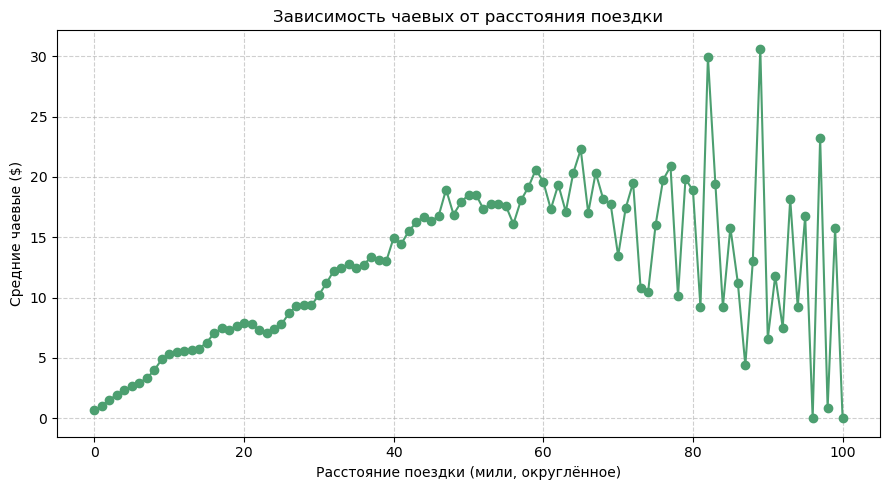

In [22]:
avg_tip_by_dist = (
    df.groupBy(F.round("trip_distance").alias("rounded_distance"))
      .agg(F.mean("tip_amount").alias("avg_tip"))
      .orderBy("rounded_distance")
)

pdf = avg_tip_by_dist.toPandas()

plt.figure(figsize=(9,5))
plt.plot(pdf["rounded_distance"], pdf["avg_tip"], marker="o", color="#4C9F70")
plt.title("Зависимость чаевых от расстояния поездки")
plt.xlabel("Расстояние поездки (мили, округлённое)")
plt.ylabel("Средние чаевые ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 💬 Вывод по признаку `tip_amount` (сумма чаевых)

Распределение признака **`tip_amount`** имеет выраженную правостороннюю асимметрию:  
большинство поездок сопровождаются малыми чаевыми — от **0 до 3 долларов**,  
а медианное значение находится около **1 $**.  
Верхний квартиль (~75%) составляет около **2.5 $**, что отражает типичное поведение пассажиров при коротких городских поездках.  

После очистки по межквартильному размаху (**IQR**) распределение стало более компактным —  
выбросы выше **10 $** встречаются редко.  

При анализе зависимости от расстояния (`trip_distance`) наблюдается закономерность:  
размер чаевых растёт с увеличением продолжительности поездки —  
длинные маршруты (например, трансферы в аэропорты) чаще оплачиваются картой и сопровождаются более высокими чаевыми.  

Таким образом, признак **`tip_amount`** демонстрирует логичную связь с экономическими характеристиками поездки —  
стоимостью и диной маршрута.


# 6.4 Анализ признака total_amount (итоговая сумма поездки)

Базовая статистика

In [18]:
df.select("total_amount").describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|         111082315|
|   mean| 16.27432498333742|
| stddev|13.875296967646042|
|    min|               1.0|
|    max|             499.8|
+-------+------------------+



## Квартильный анализ и очистка выбросов

In [17]:
# Преобразуем колонку к типу double
df = df.withColumn("total_amount", F.col("total_amount").cast("double"))

# Проверим, что тип изменился
df.printSchema()

root
 |-- vendorid: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: double (nullable = true)



In [19]:
quantiles = df.approxQuantile("total_amount", [0.25, 0.5, 0.75], 0.01)
q1, q2, q3 = quantiles
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Q1 = {q1:.2f}, Median = {q2:.2f}, Q3 = {q3:.2f}, IQR = {iqr:.2f}")
print(f"Допустимый диапазон: {lower_bound:.2f} – {upper_bound:.2f}")

df_total_clean = df.filter(
    (F.col("total_amount") >= lower_bound) &
    (F.col("total_amount") <= upper_bound)
)

print(f"Строк до очистки: {df.count():,}")
print(f"Строк после очистки: {df_total_clean.count():,}")

Q1 = 8.75, Median = 11.80, Q3 = 17.76, IQR = 9.01
Допустимый диапазон: -4.77 – 31.28
Строк до очистки: 111,082,315
Строк после очистки: 100,369,284


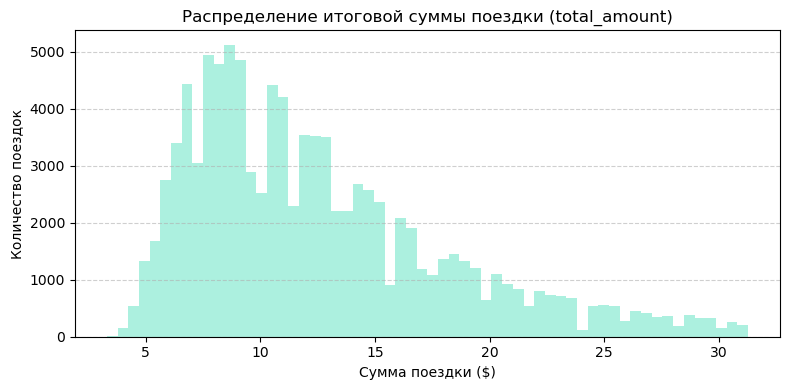

In [20]:
sample_pdf = (
    df_total_clean
    .select("total_amount")
    .sample(False, 0.001, seed=42)
    .toPandas()
)

plt.figure(figsize=(8,4))
plt.hist(sample_pdf["total_amount"], bins=60, color="#97edd7", alpha=0.8)
plt.title("Распределение итоговой суммы поездки (total_amount)")
plt.xlabel("Сумма поездки ($)")
plt.ylabel("Количество поездок")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

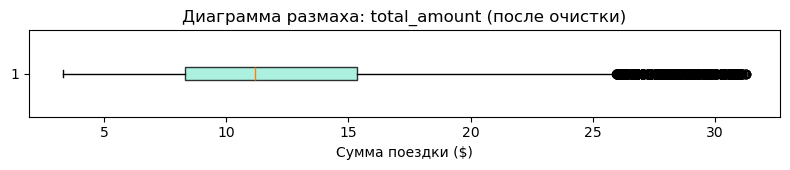

In [21]:
plt.figure(figsize=(8,1.8))
plt.boxplot(sample_pdf["total_amount"], vert=False, patch_artist=True,
            boxprops=dict(facecolor="#97edd7", alpha=0.8))
plt.title("Диаграмма размаха: total_amount (после очистки)")
plt.xlabel("Сумма поездки ($)")
plt.tight_layout()
plt.show()

### 💬 Вывод по признаку `total_amount` (итоговая сумма поездки)

Распределение признака **`total_amount`** имеет правосторонний характер:  
большинство поездок имеют итоговую стоимость до **30 $**,  
а медианное значение составляет около **13–15 $**.  

После очистки по межквартильному размаху (**IQR**) распределение стало более однородным,  
удалены редкие экстремальные значения (поездки выше 100 $).  

Такая структура характерна для городских поездок на короткие расстояния,  
при этом хвост распределения отражает редкие длительные поездки —  
например, трансферы в аэропорты или междугородние маршруты.  
Признак `total_amount` демонстрирует логичную зависимость от стоимости (`fare_amount`)  
и расстояния (`trip_distance`), что подтверждается высокой корреляцией между ними.